## Ming Lee

### Problem Statement:
#### In this problem, we ask you to look at the daily click counts at Blackhawk, and predict the upcoming click counts. The dataset is a day-level summary of the click counts.

#### Anaconda: Jupyter Noteboook

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.tsa.api as smt
import statsmodels.api as sm

from scipy.stats import boxcox

import sklearn
from sklearn.metrics import mean_squared_error

import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(font_scale=1.0)
sns.set_style("ticks")

In [3]:
df = pd.read_csv("Click Counts.txt", sep="\t")

In [4]:
df.columns = df.columns.str.strip()
df.columns

Index(['Date', 'Click Count'], dtype='object')

In [5]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(by='Date')
df.index = pd.DatetimeIndex(df['Date'])
df

,Date,Click Count
Date,,
2016-01-01,2016-01-01,2093576
2016-01-02,2016-01-02,2397260
2016-01-03,2016-01-03,2173039
2016-01-04,2016-01-04,2051240
2016-01-05,2016-01-05,1954117
...,...,...
2019-07-04,2019-07-04,2174217
2019-07-05,2019-07-05,2530250
2019-07-06,2019-07-06,2510980


In [6]:
df['Click Count'].describe()

count    1.285000e+03
mean     2.231747e+06
std      1.245358e+06
min      1.061345e+06
25%      1.652568e+06
50%      1.980385e+06
75%      2.360693e+06
max      1.371469e+07
Name: Click Count, dtype: float64

In [7]:
daily_clicks = df['Click Count']

click_p1 = daily_clicks['2016-01-01':'2016-12-31'].describe()
click_p2 = daily_clicks['2017-01-01':'2017-12-31'].describe()
click_p3 = daily_clicks['2018-01-01':'2018-12-31'].describe()
click_p4 = daily_clicks['2019-01-01':'2019-07-08'].describe()

click_periods_stats = pd.DataFrame(index=click_p1.index)
click_periods_stats['01/01/16-31/12/16'] = click_p1
click_periods_stats['01/01/17-31/12/17'] = click_p2
click_periods_stats['01/01/18-31/12/18'] = click_p3
click_periods_stats['01/01/19-08/07/19'] = click_p4

click_periods_stats

,01/01/16-31/12/16,01/01/17-31/12/17,01/01/18-31/12/18,01/01/19-08/07/19
count,3.660000e+02,3.650000e+02,3.650000e+02,1.890000e+02
mean,1.821184e+06,2.131572e+06,2.590386e+06,2.527651e+06
std,1.026365e+06,1.333380e+06,1.484570e+06,3.902522e+05
min,1.061345e+06,1.216615e+06,1.707227e+06,1.928743e+06
25%,1.396430e+06,1.639236e+06,2.018298e+06,2.210420e+06
50%,1.566509e+06,1.792765e+06,2.207098e+06,2.472397e+06
75%,1.792951e+06,2.026339e+06,2.466137e+06,2.705694e+06
max,1.125790e+07,1.371469e+07,1.364930e+07,4.226356e+06


#### Data Analysis:
* Our Data consist of Daily Clicks for the Years of: 2016, 2017, 2018, 2019
* The Average Daily Click Count for the entire dataset is 2,231,747


In [8]:
df['year'] = pd.DatetimeIndex(df.index).year
df['month'] = pd.DatetimeIndex(df.index).month
df['day'] = pd.DatetimeIndex(df.index).day
df

,Date,Click Count,year,month,day
Date,,,,,
2016-01-01,2016-01-01,2093576,2016,1,1
2016-01-02,2016-01-02,2397260,2016,1,2
2016-01-03,2016-01-03,2173039,2016,1,3
2016-01-04,2016-01-04,2051240,2016,1,4
2016-01-05,2016-01-05,1954117,2016,1,5
...,...,...,...,...,...
2019-07-04,2019-07-04,2174217,2019,7,4
2019-07-05,2019-07-05,2530250,2019,7,5
2019-07-06,2019-07-06,2510980,2019,7,6


In [9]:
df.isnull().sum()

Date           0
Click Count    0
year           0
month          0
day            0
dtype: int64

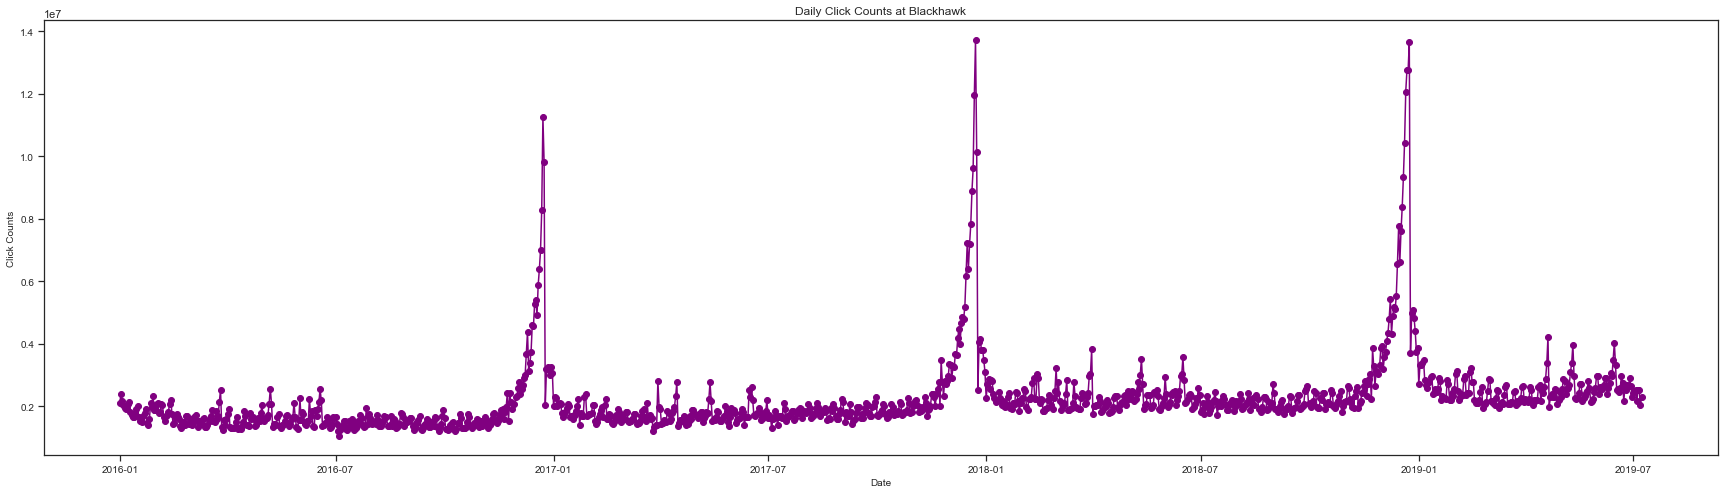

In [10]:
fig, ax = plt.subplots(figsize=(30, 8))

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
    
ax.plot(df.index.values,
        df['Click Count'].values,
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="Click Counts",
       title="Daily Click Counts at Blackhawk")

plt.show()

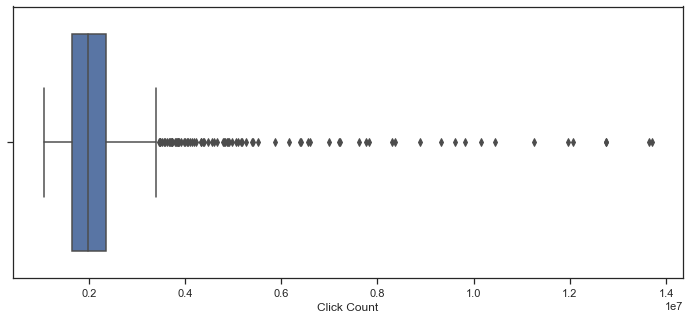

In [11]:
plt.figure(figsize=(12,5))
sns.boxplot(df['Click Count'])
plt.show()

#### Data contains outliers; however, we need all the data for our model

Text(0.5, 1.0, 'Monthly averages of Clicks of each year: 2016, 2017, 2018, 2019')

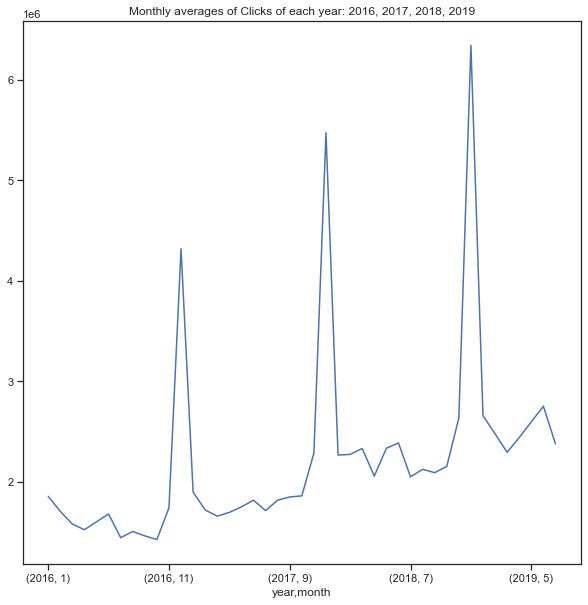

In [12]:
plt.figure(figsize=(10,10))
monthly_df = df.groupby(['year','month']).mean()['Click Count']
monthly_df.plot(kind='line')
plt.title('Monthly averages of Clicks of each year: 2016, 2017, 2018, 2019')

#### From the Plot of each Year by Month we see a steadily increasing trend and seasonal spikes around the end of each year

In [13]:
def test_stationarity(timeseries, rolling=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(rolling).mean()
    rolstd = timeseries.rolling(rolling).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.title(' Daily click counts at Blackhawk')
    plt.xlabel('Time - periods')
    plt.ylabel('Clicks')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:') 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput['p-value'] < 0.05:
        print('The time series is stationary')
    else:
        print('The time series is not stationary')

In [14]:
ts = df['Click Count']

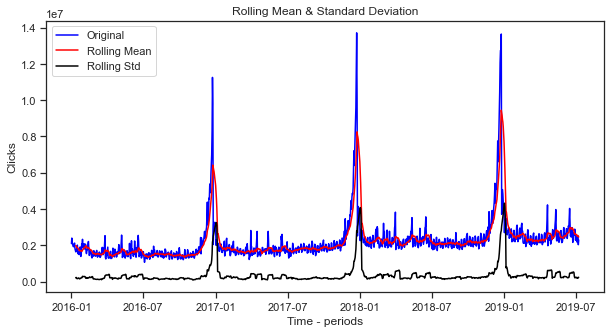

Results of Dickey-Fuller Test:
Test Statistic                   -5.502094
p-value                           0.000002
#Lags Used                       14.000000
Number of Observations Used    1270.000000
Critical Value (1%)              -3.435510
Critical Value (5%)              -2.863818
Critical Value (10%)             -2.567983
dtype: float64
The time series is stationary


In [15]:
test_stationarity(ts)

In [16]:
kpss_test = kpss(ts)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('The time series is stationary')
else:
    print('The time series is not stationary')

KPSS Statistic: 1.144203
Critical Values @ 0.05: 0.46
p-value: 0.010000
The time series is not stationary


### Decomposition of Time Series
* Signal, Trend, Season, Residuals


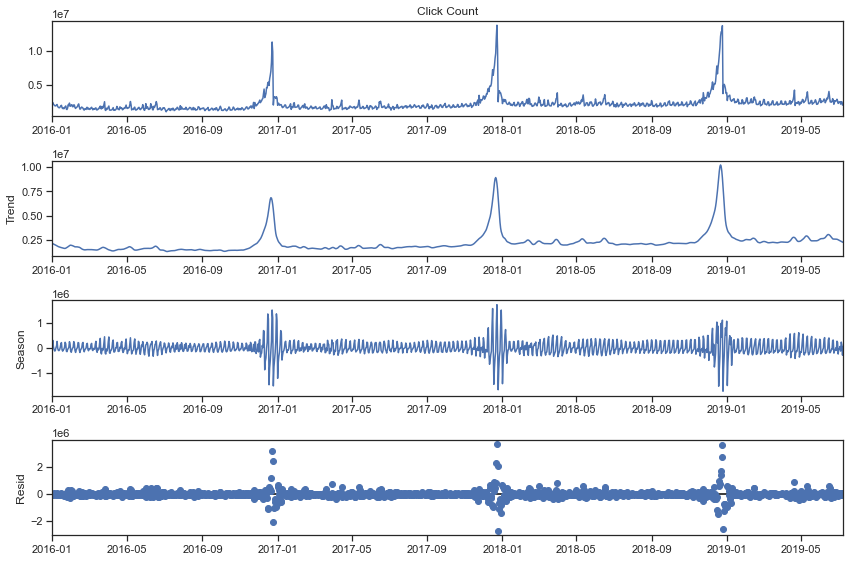

In [17]:
from statsmodels.tsa.seasonal import STL
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=13)
stl = STL(ts, seasonal=7)
res = stl.fit()
fig = res.plot()

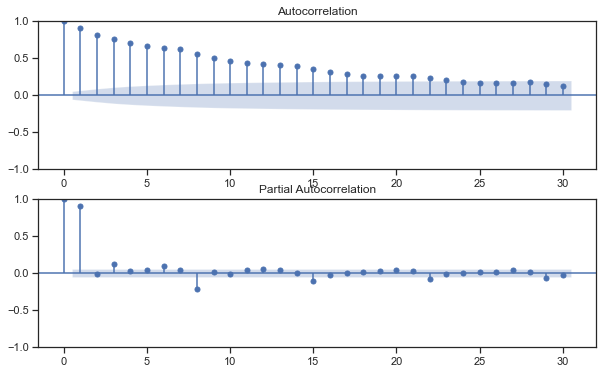

In [18]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

fig = sm.graphics.tsa.plot_acf(ts, lags=30, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(ts, lags=30, ax=ax2)

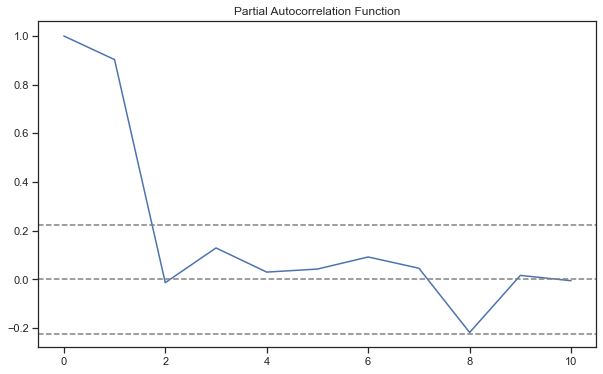

In [19]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,11), pacf(ts, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

#### The PACF curve drops to 0 between lag values 1 and 2. Thus, optimal value of p  is 1 or 2.

#### The series does not pass the KPSS test; therefore, the series is not stationary
#### To make the series stationary and remove the seasonal spike for each year in our series
#### we need to perform transformation and differencing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


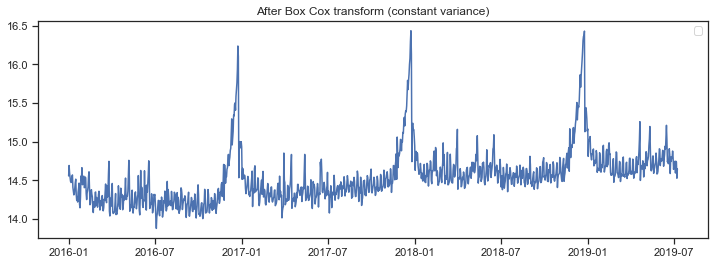

In [20]:
data_boxcox = pd.Series(boxcox(ts, lmbda=0), index = df.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox)
plt.legend(loc='best')
plt.title('After Box Cox transform (constant variance)')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


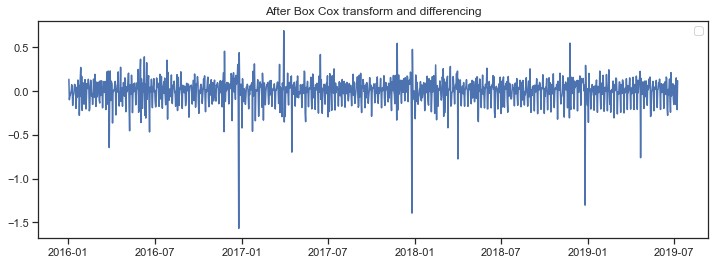

In [21]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), df.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff)
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

#### drop the first value which is NA

In [22]:
data_boxcox_diff.dropna(inplace=True) 
data_boxcox_diff.tail()

Date
2019-07-04   -0.152023
2019-07-05    0.151650
2019-07-06   -0.007645
2019-07-07   -0.211238
2019-07-08    0.119885
dtype: float64

#### Do both ADF and KPSS Test to make sure our series is stationary

In [23]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

kpss_test = kpss(data_boxcox_diff)
if adf_test[1] < 0.05:
    print('The time series is stationary')
else:
    print('The time series is not stationary')
print('---------------------------------')
print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('The time series is stationary')
else:
    print('The time series is not stationary')

ADF Statistic: -9.004434
Critical Values @ 0.05: -2.86
p-value: 0.000000
The time series is stationary
---------------------------------
KPSS Statistic: 0.046071
Critical Values @ 0.05: 0.46
p-value: 0.100000
The time series is stationary


In [24]:
def train_test_split(timeseries, lags_for_prediction=14):
    split=len(timeseries)-lags_for_prediction
    train=timeseries[:split]
    test=timeseries[split:]
    return train, test

train_series, test_series = train_test_split(df['Click Count'])

In [25]:
train_data_boxcox, test_data_boxcox = train_test_split(data_boxcox)

In [26]:
train_data_boxcox_diff, test_data_boxcox_diff = train_test_split(data_boxcox_diff)

In [27]:
train_data_boxcox.shape, test_data_boxcox.shape

((1271,), (14,))

In [28]:
train_data_boxcox_diff.shape, test_data_boxcox_diff.shape

((1270,), (14,))

### Hyper-Parameter Search for SARIMA model

In [29]:
from tqdm import tqdm_notebook
import itertools
import warnings
warnings.filterwarnings('ignore')


p = d = q = range(0,3) 
pdq = list(itertools.product(p,d,q))  
p2 = d2 = q2 = range(0, 2) 
pdq2 = list(itertools.product(p2,d2,q2)) 
s = 12

pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
aics = []


for combination in pdq:
    for seasonal_combination in tqdm_notebook(pdqs2):
        try:
            model = sm.tsa.statespace.SARIMAX(train_data_boxcox, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            model = model.fit(disp=False)
            combs.update({model.aic : [combination, seasonal_combination]})
            aics.append(model.aic)
            print('ARIMA{}x{}12 - AIC:{}'.format(combination, seasonal_combination, model.aic))
        except:
            continue
            
best_aic = min(aics)

  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10414.212108465385
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8730.357002242112
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:542.2251886305372
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:446.93545097227434
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:642.8106554701349
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:548.2728451139849
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:499.04183275993097
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:282.1881728486517


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:8666.483398895154
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6997.433588742999
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-112.7232325567472
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-355.9480407295119
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-24.264000219968963
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-267.85647332256224
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-230.43907686792357
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-479.8682298215324


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:7075.449986830359
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:5571.315301910928
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:-240.41372894179258
ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:-678.6100518692756
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:-158.11476238118632
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:-557.3096194032378
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:-459.17338477131636
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:-726.1922537729026


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-1160.968578699903
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-1193.3010893205046
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-100.17983737380138
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-1087.0584657239292
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-1186.8557472929128
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-1195.5977722005482
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-501.7259407879952
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-1111.5286186157723


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-1204.9997388170557
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-1245.6348007233316
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-140.42756597412136
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-1130.7248841416376
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-1232.5910004610462
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-1251.187729361777
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-506.41453338042675
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-1156.9141715002434


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:-1311.6697060904771
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:-1329.0917802233148
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:-309.10481659247523
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:-1235.2604163641522
ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC:-1323.1424990529526
ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:-1339.627538763002
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:-627.6158773285435
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:-1245.5695002653522


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:-119.35614684370289
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:-135.07455305444145
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:898.3867581164579
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:-54.61526224672397
ARIMA(0, 2, 0)x(1, 0, 0, 12)12 - AIC:-134.8799125143604
ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:-134.836256103447
ARIMA(0, 2, 0)x(1, 1, 0, 12)12 - AIC:436.9625410531535
ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:-68.85510880647863


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:-1149.908164216716
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:-1181.817388269148
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:-89.93333281796089
ARIMA(0, 2, 1)x(0, 1, 1, 12)12 - AIC:-1069.1659906443822
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:-1175.4969608261185
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:-1184.002110731804
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:-490.3381719115331
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:-1093.3311050785985


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:-1193.2466283341364
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:-1233.3663497593625
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:-129.38105436787282
ARIMA(0, 2, 2)x(0, 1, 1, 12)12 - AIC:-1112.1197518232962
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:-1220.5641690992393
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:-1238.7517952302153
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:-494.8274117698545
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:-1138.0631398546448


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-1150.7614134393602
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-1183.10018126204
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-302.78804479981375
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-1150.0744999758733
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-1176.6714021736238
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-1185.3617498253973
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-634.7484063498902
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-1163.9637934796256


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-1194.8074008160256
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-1235.252444699724
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-308.9687266692234
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-1166.4559058509362
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-1222.3442906087253
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-1240.6514904738501
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-636.8429350383187
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-1185.8205604284585


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:-1301.4661015673787
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:-1318.8880362391583
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:-365.52173497997586
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:-1249.7152031764722
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:-1275.1751973121752
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:-1270.2599111811705
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:-668.0767146992488
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:-1258.7008150083648


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-1182.5425954928896
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-1222.8750843994524
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-112.30908302187498
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-1108.5434839150776
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-1212.4430637897078
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-1225.957211490594
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-503.6250473338178
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-1137.0239998168477


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-1295.6434506468036
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-1323.4573545987503
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-294.8265789451288
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-1219.6276135989115
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-1315.480220342601
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-1330.3329378759604
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-613.3111338319325
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-1238.1163553773997


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:-1314.7390320442055
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:-1333.9857150306962
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:-309.01215183288724
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:-1238.2733861310016
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:-1328.181916973954
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:-1342.7174250190628
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:-645.6954672649205
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:-1250.499179274387


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:-434.3025461068142
ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:-490.5889088643757
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:671.9006424245166
ARIMA(1, 2, 0)x(0, 1, 1, 12)12 - AIC:-367.56442944973224
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:-486.95616886194625
ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:-488.5889693257204
ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:167.31636875897027
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:-418.6391561570615


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:-1171.2095229950842
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC:-1211.0203616733704
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC:-101.87100988635254
ARIMA(1, 2, 1)x(0, 1, 1, 12)12 - AIC:-1090.288131276949
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:-1200.770494545134
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:-1213.9895493490924
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:-492.1186846386644
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:-1118.435425283845


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:-1154.160593686754
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:-1183.0828394305963
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:-153.78928580219605
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:-1069.9389216047564
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:-1177.473036644968
ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:-1183.4416917393141
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:-526.0807592593551
ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:-1089.267801120814


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:-1172.352447695038
ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:-1212.6050262143733
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:-304.23587039946943
ARIMA(2, 0, 0)x(0, 1, 1, 12)12 - AIC:-1157.9476152852685
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:-1202.2320315844067
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:-1215.6263677486172
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:-635.863971933937
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:-1176.116922725283


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:-1154.890601696432
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:-1174.6568461040602
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:-379.7442361643561
ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:-1152.0698530504137
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:-1177.9332129870952
ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:-1145.5399468371374
ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:-676.3686221482683
ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:-1250.0376640139457


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:-1205.3534371702863
ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:-1239.015025322344
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:-363.8447229383441
ARIMA(2, 0, 2)x(0, 1, 1, 12)12 - AIC:-1251.9351765244958
ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:-1226.6115367234129
ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:-1195.3340816197679
ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:-681.5873540836428
ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:-1262.727760421942


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:-1246.084662748267
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:-1266.4214016039919
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:-250.05843682327173
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:-1171.038059164328
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:-1258.5448658980179
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:-1276.2827163931454
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:-550.7247573263468
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:-1182.418489948087


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:-1318.351555646765
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:-1337.4635543115473
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:-306.34561282280765
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:-1241.7639888422773
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:-1332.1479231607343
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:-1345.6534348044295
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:-661.0248424989634
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:-1254.303680760665


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:-1397.2773716839315
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:-1423.1505103754166
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:-371.7265143748326
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:-1317.0864961760353
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:-1424.3467190521264
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:-1380.2537579542236
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:-890.022409304606
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:-1308.723647848287


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:-659.7725551237193
ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:-690.15720977406
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:346.65910177478054
ARIMA(2, 2, 0)x(0, 1, 1, 12)12 - AIC:-591.382925035658
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:-679.7335540182396
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:-695.9133545062143
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:28.187687902754703
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:-610.33021271768


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:-1234.2976820902986
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:-1254.2893915364587
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:-238.93516659571105
ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:-1152.4332210263779
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:-1246.5698219857534
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:-1263.9013001305884
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:-538.8758359860051
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:-1163.6425607056458


  0%|          | 0/8 [00:00<?, ?it/s]

ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:-1305.4719944768042
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:-1318.1778614334225
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:-188.58316595805445
ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:-1217.9967109438342
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:-1313.8462862341976
ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:-1221.4883170384664
ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:-535.029573954637
ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:-1230.4154595448697


In [30]:
best_aic = min(aics)
best_aic

-1424.3467190521264

In [31]:
print('best aic is: ', round(best_aic, 3))
print(40*'==')
print ('ARIMA parameters: ', '\n', 'AR: ', combs[best_aic][0][0], '\n', 'I: ',combs[best_aic][0][1], '\n', 'MA: ',combs[best_aic][0][2])
print('Seasonal parameters:', combs[best_aic][1])

best aic is:  -1424.347
ARIMA parameters:  
 AR:  2 
 I:  1 
 MA:  2
Seasonal parameters: (1, 0, 0, 12)


In [32]:
positive_aics = list(filter(lambda x : x > 0, aics))
  
# printing result 
print("List after filtering : " + str(positive_aics))
best_aic = min(positive_aics)

List after filtering : [10414.212108465385, 8730.357002242112, 542.2251886305372, 446.93545097227434, 642.8106554701349, 548.2728451139849, 499.04183275993097, 282.1881728486517, 8666.483398895154, 6997.433588742999, 7075.449986830359, 5571.315301910928, 898.3867581164579, 436.9625410531535, 671.9006424245166, 167.31636875897027, 346.65910177478054, 28.187687902754703]


In [33]:
print('best aic is: ', round(best_aic, 3))
print(40*'==')
print ('ARIMA parameters: ', '\n', 'AR: ', combs[best_aic][0][0], '\n', 'I: ',combs[best_aic][0][1], '\n', 'MA: ',combs[best_aic][0][2])
print('Seasonal parameters:', combs[best_aic][1])

best aic is:  28.188
ARIMA parameters:  
 AR:  2 
 I:  2 
 MA:  0
Seasonal parameters: (1, 1, 0, 12)


In [34]:
model = SARIMAX(train_data_boxcox, order=(2, 2, 1), seasonal_order=(1, 1, 0, 12)) # best so far
#model = SARIMAX(train_data_boxcox, order=(2, 2, 0), seasonal_order=(1, 1, 0, 12))
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.071151
ar.L2      -0.200847
ma.L1      -0.999814
ar.S.L12   -0.478569
sigma2      0.037490
dtype: float64


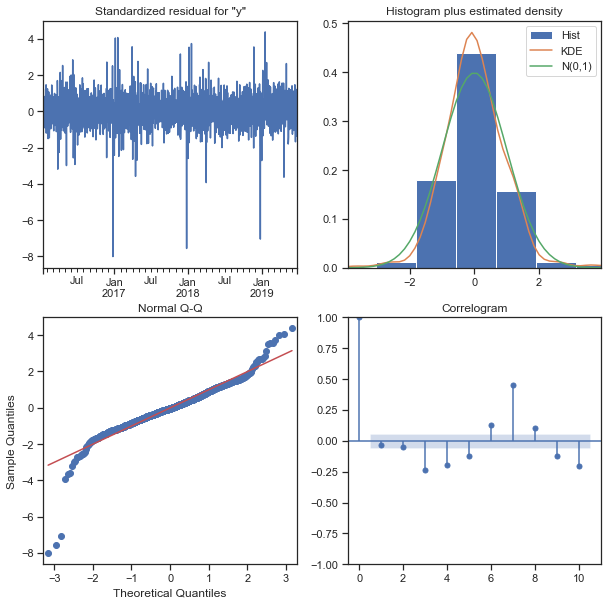

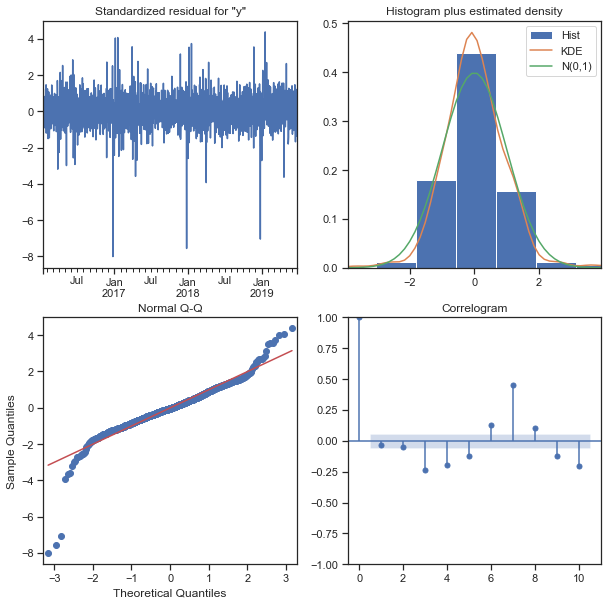

In [35]:
model_fit.plot_diagnostics(figsize=(10, 10))

###  From the histogram we can see that our residuals follow a normal distribution


#### Recover original time series forecast

In [36]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

In [37]:
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1271
Model:             SARIMAX(2, 2, 1)x(1, 1, [], 12)   Log Likelihood                 274.438
Date:                             Mon, 06 Jun 2022   AIC                           -538.876
Time:                                     11:05:30   BIC                           -513.193
Sample:                                 01-01-2016   HQIC                          -529.224
                                      - 06-24-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0712      0.028     -2.558      0.011      -0.126      -0.017
ar.L2         -0.2008      

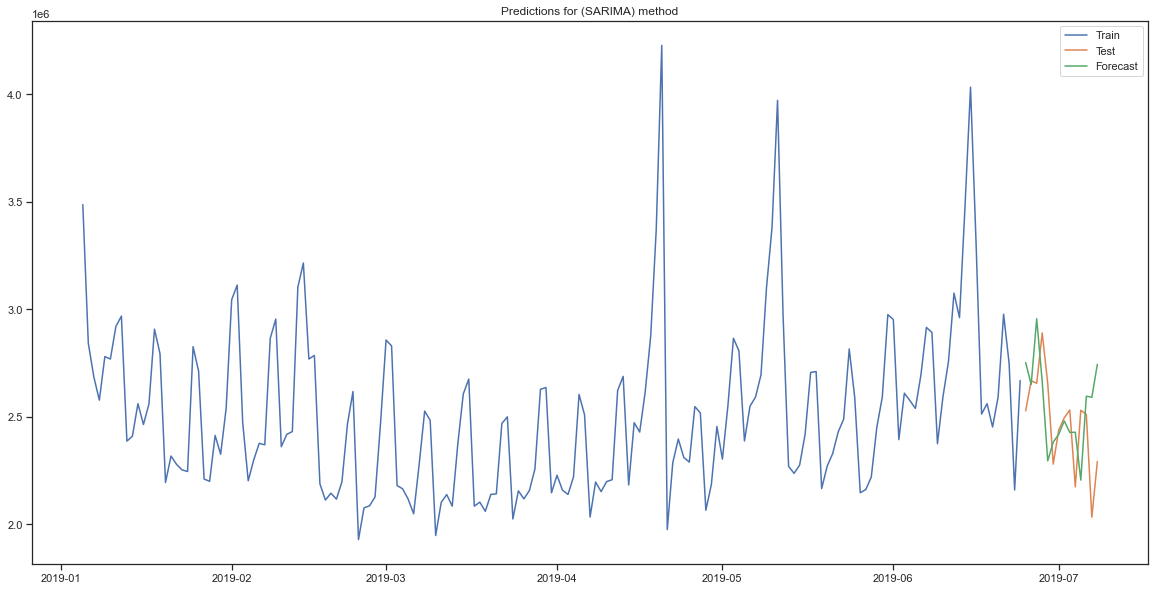

In [38]:
plt.figure(figsize=(20,10))
plt.plot(train_series[1100:], label='Train')
plt.plot(test_series, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_series.index.min():], label='Forecast')
plt.legend(loc='best')
plt.title('Predictions for (SARIMA) method')
plt.show()

In [39]:
rmse = np.sqrt(mean_squared_error(test_series, y_hat_sarima['sarima_forecast'][test_series.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test_series-y_hat_sarima['sarima_forecast'][test_series.index.min():])/test_series)*100,2)

### RMSE and MAPE 

In [40]:
print("rmse: ",rmse)
print("mape: ",mape)

rmse:  271991.41
mape:  9.09


In [41]:
y_predict = y_hat_sarima['sarima_forecast'][test_series.index.min():]

In [42]:
pd.options.display.float_format = '{:.0f}'.format

data = {"Actual": test_series,
        "Predicted": y_predict}

dataframe = pd.concat(data, axis=1)
dataframe

,Actual,Predicted
2019-06-25,2527256,2751861
2019-06-26,2666876,2649686
2019-06-27,2655708,2955645
2019-06-28,2889752,2664179
2019-06-29,2655321,2294774
2019-06-30,2279690,2382081
2019-07-01,2438360,2418570
2019-07-02,2495127,2480448
2019-07-03,2531195,2426953
2019-07-04,2174217,2427971


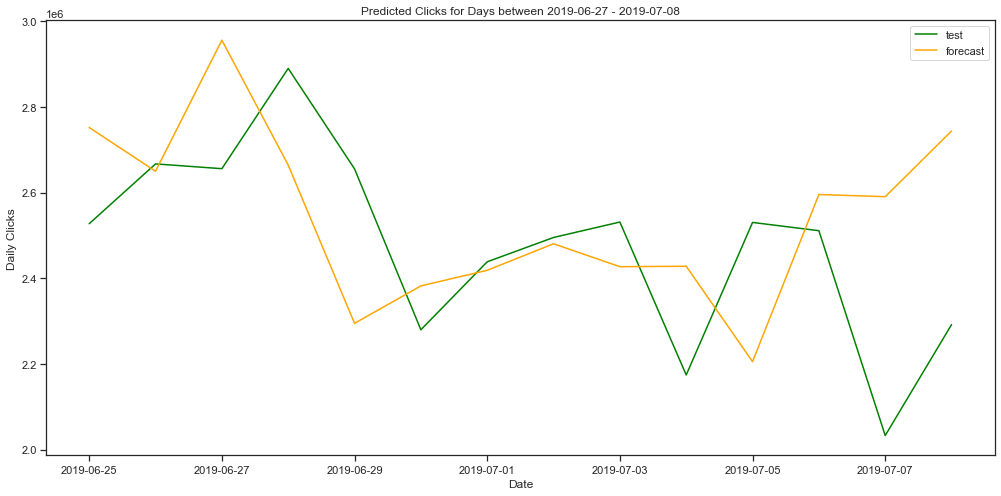

In [43]:
plt.figure(figsize=(17, 8))
plt.plot(test_series, color='green', label = 'test')
plt.plot(y_predict, color='orange', label = 'forecast')
plt.title('Predicted Clicks for Days between 2019-06-27 - 2019-07-08')
plt.ylabel('Daily Clicks')
plt.xlabel('Date')
plt.legend(loc='best')
plt.grid(False)
plt.show()

### Model Evaluation
####  After adjusting for the seasonal effects towards the end of each year and
####  Using SARIMA 
####  Our models gives accurate results in a weekly and bi-weekly period